In [188]:
import matplotlib.pyplot as plt
import re

In [6]:
from collections import defaultdict

def parse_gamma_lines(lines):
    p = re.compile(r'Current gamma=(?P<gamma>0.[0-9]*) (?P<time>\d+)')
    res = defaultdict(list)
    for aline in lines:
        match=p.match(aline)
        if match:
            d = match.groupdict()
            gamma = float(d['gamma'])
            ts = int(d['time'])

            res[gamma].append(ts)
            
    return res
    
    
def parse_stream_step1(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    return {gamma: (t[1]-t[0]) for gamma, t in parse_gamma_lines(lines).items()}

    
def parse_stream_step3(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    # here we have 3 values (two phases) (merging and converting)
    merging= {gamma: (t[1]-t[0]) for gamma, t in parse_gamma_lines(lines).items()}
    converting = {gamma: (t[2]-t[1]) for gamma, t in parse_gamma_lines(lines).items()}
    return merging, converting


def totals(dicts):
    res = defaultdict(lambda: 0)
    for g in dicts[0].keys():
        for d in dicts:
            res[g]+=d[g]
    return res

In [95]:
stream_parts = [6, 10, 16, 32]

In [96]:
stream_results = {}
for part in stream_parts:
    p1 =  parse_stream_step1(fname=f"../res/newestcluster/times/stream/part{part}/s1.out")
    p2 =  parse_stream_step1(fname=f"../res/newestcluster/times/stream/part{part}/s2.out")
    p3, p4 =  parse_stream_step3(fname=f"../res/newestcluster/times/stream/part{part}/s3.out")
    total = totals([p1, p2, p3, p4])
    
    stream_results[part] = [p1, p2, p3, p4, total]
    

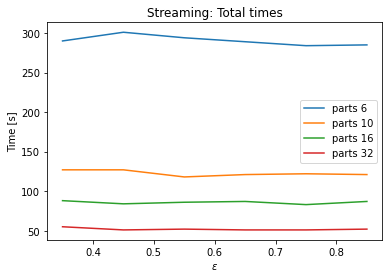

In [56]:
plt.title('Streaming: Total times')

for part, [p1, p2, p3, p4, total] in stream_results.items():
        plt.plot(total.keys(), total.values(), label=f"parts {part}")
        
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');
plt.savefig('../fig/times-streamed.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [86]:
def convert_to_epsilon(results, total_index=4):
    epsilon_results = {}
    for epsilon in results[6][0].keys():
        epsilon_results[epsilon] = {part:results[part][total_index][epsilon] for part in results.keys()}
        
    return epsilon_results
    

In [87]:
stream_epsilon = convert_to_epsilon(stream_results)

In [89]:
merge_epsilon = convert_to_epsilon(merge_results, total_index=3)

In [100]:
selected_eps = [0.35, 0.55, 0.85]

In [189]:
! ls ../fig/

compres.eps    eff.svg		     precrecall.svg  stream.eps
compresf1.svg  full_compression.svg  prreauc.eps     streammergefull.eps
compres.pdf    full_pre_re.svg	     prreauc.pdf     streammergefull.pdf
compres.svg    par.eps		     prreauc.svg     streammergefull.svg
crecall.svg    par.pdf		     prrec06.eps     stream.pdf
dist01.svg     par.svg		     prrec06.pdf     stream.svg
dist04.eps     part_auc.svg	     prrec06.svg     subparts.eps
dist04.pdf     part_comp.svg	     randoms.eps     subparts.pdf
dist04.svg     part-merged.eps	     randoms.pdf     subparts.svg
dist06.eps     part-merged.pdf	     randoms.svg     times-streamed.svg
dist06.pdf     part-streamed.eps     stab.eps
dist06.svg     part-streamed.pdf     stab.pdf
effective.svg  precrecall.pdf	     stab.svg


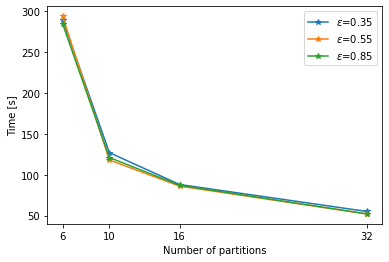

In [197]:
plt.xticks(stream_parts)

for epsilon, vals in stream_epsilon.items():
    if epsilon in selected_eps:
        plt.plot(vals.keys(), vals.values(),'-*', label=f"$\epsilon$={epsilon}")
    
plt.legend()
plt.xlabel("Number of partitions")
plt.ylabel("Time [s]");
plt.savefig('../fig/stream-times.svg', format='svg', bbox_inches = 'tight', dpi=1000);

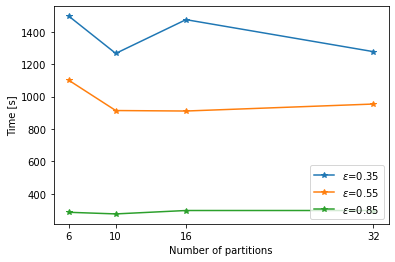

In [213]:
plt.xticks(stream_parts)

for epsilon, vals in merge_epsilon.items():
    if epsilon not in selected_eps:
        continue
    plt.plot(vals.keys(), vals.values(),'-*', label=f"$\epsilon$={epsilon}")
    
plt.legend(loc=4)
#plt.xlim(6, 45) 
plt.xlabel("Number of partitions")
plt.ylabel("Time [s]");
plt.savefig('../fig/merge-times.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [10]:
def plot_part(part):
    [net_calc, net_update, merge, convert, total] = part
    
    plt.plot(net_calc.keys(), net_calc.values(), label='Network cration')
    plt.plot(net_update.keys(), net_update.values(), label='Network update')
    plt.plot(merge.keys(), merge.values(), label='Merging')
    plt.plot(convert.keys(), convert.values(), label='Converting')
    
    plt.plot(total.keys(), total.values(), label='Total')
    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

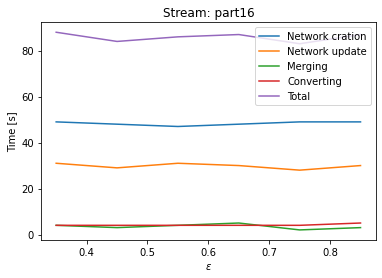

In [11]:
plt.title('Stream: part16')
plot_part(stream_results[16])

In [200]:
def plot_barpart(part):
    plt.xticks(list(part[0].keys()))
    [net_calc, net_update, merge, convert, total] = part
    width = 0.05
    plt.bar(net_calc.keys(), net_calc.values(),width=width, label='Network creation', color='orange')
    plt.bar(net_update.keys(), net_update.values(), width, label='Distribution update')
    plt.bar(merge.keys(), merge.values(), width, label='Merging', color='lightblue')
    #plt.bar(convert.keys(), convert.values(),width,  label='Converting')
    
    #plt.plot(total.keys(), total.values(), label='Total')
    plt.ylim(0,100)
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

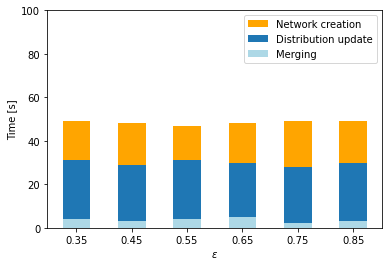

In [203]:
plot_barpart(stream_results[16])
plt.savefig('../fig/stream-stack.svg', format='svg', bbox_inches = 'tight', dpi=1000);

## Merge

In [133]:
! ls ../res/newestcluster/times/merge/

part10 part16 part32 part6


In [12]:
merge_parts = [6, 10, 16, 32]

In [51]:
merge_results = {}
for part in merge_parts:
    net_calc, convert =  parse_stream_step3(fname=f"../res/newestcluster/times/merge/part{part}/s1.out")
    merge =  parse_stream_step1(fname=f"../res/newestcluster/times/merge/part{part}/s2.out")

    total = totals([net_calc, convert, merge])
    
    merge_results[part] = [net_calc, convert, merge, total]

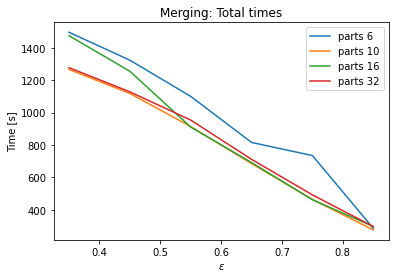

In [52]:
plt.title('Merging: Total times')

for part, [net_calc, convert, merge, total] in merge_results.items():
        plt.plot(total.keys(), total.values(), label=f"parts {part}")
        
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');
plt.savefig('../fig/times-streamed.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [184]:
def plot_merge_part(part):
    [net_calc, convert, merge, total] = part
    
    plt.plot(net_calc.keys(), net_calc.values(), label='Network creation')
    plt.plot(convert.keys(), convert.values(), label='Conversion')
    plt.plot(merge.keys(), merge.values(), label='Merging')
    
    
    plt.plot(total.keys(), total.values(), label='Total')
    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');
    
    
def plot_barpart2(part):
    plt.xticks(list(part[0].keys()))
    [net_calc, convert, merge, total] = part
    width = 0.05
    #plt.bar(convert.keys(), convert.values(), width, label='Network update')
    plt.bar(merge.keys(), merge.values(), width, label='Merging', color='lightblue')
    plt.bar(net_calc.keys(), net_calc.values(),width=width, label='Network creation', color='orange')
    

    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

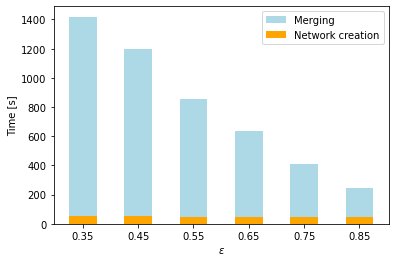

In [202]:
#plt.title('Merge: part16 stacked')
plot_barpart2(merge_results[16])
plt.savefig('../fig/merge-stack.svg', format='svg', bbox_inches = 'tight', dpi=1000);

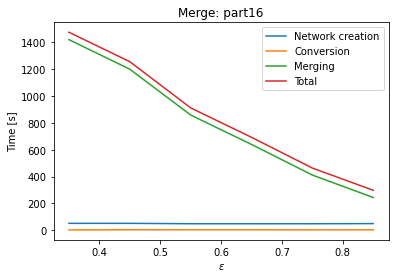

In [146]:
plt.title('Merge: part16')
plot_merge_part(merge_results[16])


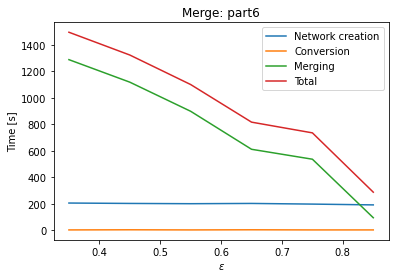

In [53]:
plt.title('Merge: part6')
plot_merge_part(merge_results[6])

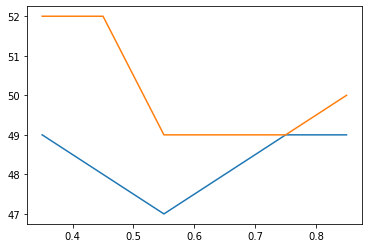

In [38]:
plt.plot(snet_calc.keys(), snet_calc.values())
plt.plot(net_calc.keys(), net_calc.values())

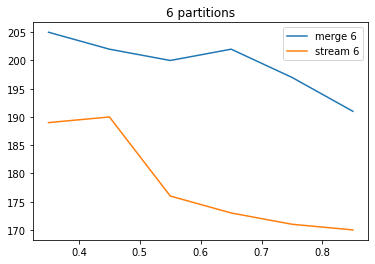

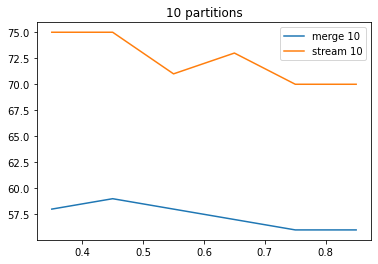

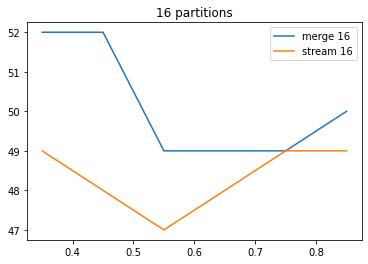

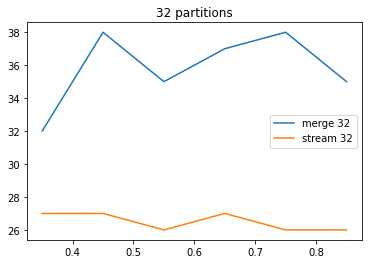

In [43]:
for s in merge_parts:
    [net_calc, convert, merge, total] = merge_results[s]
    [snet_calc, snet_update, smerge, sconvert, stotal] = stream_results[s]
    
    plt.figure(s)
    plt.title(f"{s} partitions")
    plt.plot(net_calc.keys(), net_calc.values(), label=f"merge {s}")
    plt.plot(snet_calc.keys(), snet_calc.values(), label=f"stream {s}")
    plt.legend()

In [55]:
# you piece of git